# Dorsal Decoding on Word Identification

In [1]:
#Load the required libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Model,load_model
from keras import backend as K
from keras import models, layers
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
import re
import json
import seaborn as sns

from IPython.display import display, HTML
from pdb import set_trace

%matplotlib inline
sns.set()

## Data Preprocessing

In [9]:
#create dicts from csv
##------------------------------ Dataset -------------------------------------##
import csv
import threading


#csv.field_size_limit(10**7)

def read_dict(path):
    'Reads Python dictionary stored in a csv file'
    dictionary = {}
    for key, val in csv.reader(open(path)):
        dictionary[key] = val
    return dictionary

# Load partitions
partition = read_dict('/PATH/dicts/partition.csv')

def read_patterns(csv_file):
    '''
    Reads in target patterns of the form:
        label,v1,v2,...,vN
    '''
    pattern_dict = {}
    with open(csv_file,'r') as f:
        for line in f:
            atoms = line.strip().split(',')
            word = atoms[0]
            pattern = np.array([float(x) for x in atoms[1:]])
            pattern_dict[word] = pattern
    return pattern_dict

# Load dictionary of labels
labels = read_patterns('/PATH/dicts/labels_dorsalsoftmax.csv')
#print(labels)


exec("partition['train'] = " + partition['train'])
exec("partition['validation'] = " + partition['validation'])
exec("partition['test'] = " + partition['test'])

# # Final computations
# partition['train'] = partition['train'] 
# partition['validation'] = partition['validation']
# partition['test'] = partition['test']

partition['full'] = partition['train'] + partition['validation'] + partition['test']
partition['train'] = partition['train'] + partition['validation']
partition['validation'] = partition['test']

In [10]:
#Define the Data Generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    my_list = [] #global variable for getting the IDs
    my_labels = [] #global variable for getting the labels
    def __init__(self, list_IDs, labels, batch_size=8800, dim=(226,211), #n_channels=1,
                 n_classes=883, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.my_list = []
        self.my_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # FA and NS added this part to get the names of the words
        if index == 0:
            indexes2 = self.indexes[index*8800:(index+1)*8800] #7900 become 800 for the val data
            list_IDs_temp2 = [self.list_IDs[k] for k in indexes2]
            self.my_list = list_IDs_temp2 # This is for getting shuffled list_IDs for get_my_list
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        #check shape
        #print('X : shape = %s, type = %s' % (X.shape, X.dtype) ) # If np.array
        #print('y : shape = %s, type = %s' % (y.shape, y.dtype) )

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        y = np.empty((self.batch_size, 226)) #226 is the max len here
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('/PATH/Cochs/' + ID + '.npy') #data1 for the toy

            # Store class
            y[i] = self.labels[ID]
        
        self.my_labels = y
       
        return X, y#keras.utils.to_categorical(y, num_classes=self.n_classes)

In [11]:
# Parameters for the Data Generator
params = {'dim': (226,211),
          'batch_size': 8800,
          'n_classes': 883,
          #'n_channels': 1,
          'shuffle': True}

# Datasets
partition = partition
labels = labels

# Generators
full_generator = DataGenerator(partition['full'], labels, **params)
training_generator = DataGenerator(partition['train'], labels, **params) #9 token per word
validation_generator = DataGenerator(partition['validation'], labels, **params) #1 token per word

In [12]:
#Load the model and chose the penultimate layer
import tensorflow as tf

model = tf.keras.models.load_model('/bestdorsalmodel.hd5f')
#model.summary()
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer('lstm').output)
intermediate_layer_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_input (InputLayer)   [(None, 226, 211)]        0         
_________________________________________________________________
masking (Masking)            (None, 226, 211)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 226, 512)          1482752   
Total params: 1,482,752
Trainable params: 1,482,752
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Get the features from the model for the test data
features = intermediate_layer_model.predict(full_generator, verbose=0)
print(features.shape)
features = features[:,0:225,:] #to choose the features from the first 25 time slices
#features = features[:,100,:] #to choose the features from the first 25 time slices
features = features.reshape(8800,225*512) # reshape so that 3D to 2D
print(features.shape)

(8800, 226, 512)
(8800, 115200)


In [14]:
#Get the labels from the Data Generator
y = full_generator.my_labels[:,0]
y = np.array(y, dtype='int64')
print(y.shape)

(8800,)


In [16]:
#put the features to a data frame
data = pd.DataFrame(features) #X_new if you do feature selection
#data.head()

#Get word IDs from the Data Generator
data = pd.DataFrame(data, columns=data.columns, index=data.index)
data['Words'] = np.array(full_generator.my_list)
data = data.set_index('Words')

#Get the labels from the Data Generator
#data['Labels'] = test_generator.my_labels[:,0]

#save the data frame and look at the data
#data.to_csv('/autofs/space/euler_001/users/lstm/data.csv')
data.head

<bound method NDFrame.head of                     0         1         2         3         4         5       \
Words                                                                          
richness-Alex    -0.055774 -0.026871  0.009833 -0.123424  0.014503 -0.010172   
train-Vicki      -0.032187  0.008142 -0.021295 -0.105000  0.036694 -0.001743   
viewer-Princess  -0.052832 -0.008984 -0.005831 -0.101934  0.032042  0.027285   
informing-Junior -0.049660 -0.006649 -0.013601 -0.111641  0.033593  0.014629   
violation-Kathy  -0.047476 -0.018963 -0.014243 -0.080925  0.031408  0.014139   
...                    ...       ...       ...       ...       ...       ...   
misconduct-Alex  -0.051416 -0.013680  0.010967 -0.142129  0.011731 -0.009502   
encourage-Agnes  -0.030266  0.027517 -0.052818 -0.124104  0.039695  0.034890   
normally-Alex    -0.056694 -0.038689 -0.000093 -0.143957  0.017283  0.012306   
sharing-Bruce    -0.028237 -0.012081 -0.063159 -0.044511  0.040709  0.039395   
helping-Ra

# Steps to Clustering

## PCA for Just Visual

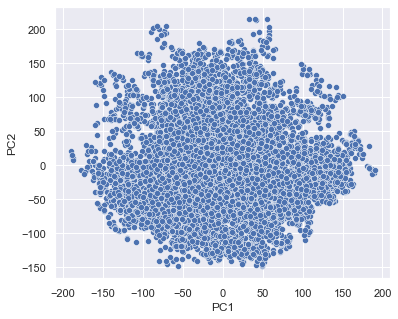

In [18]:
#Scaling and Dimensionality Reduction
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline(steps=[
  ('scaler', StandardScaler(with_mean=False)),
  ('dim_reduction', PCA(n_components=2, random_state=0))
])

pc = pipeline.fit_transform(data)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=pc[:,0], y=pc[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2");

In [19]:
#Print out the PCA explained variance
x = StandardScaler(with_mean=False).fit_transform(data)
pca = PCA(n_components=2)
pca.fit(x)
print(pca.explained_variance_ratio_)

[0.04219902 0.04035584]


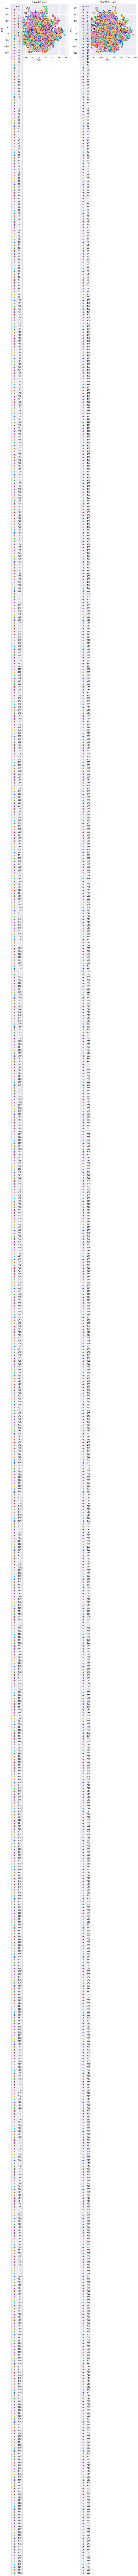

In [22]:
#Just for plotting purposes we use PCA and plot the data on two best features after PCA.
# Create clusters using Agglomerative hierarchical clustering#
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 883, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(pc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y, palette='bright', ax=ax1);
ax1.set(xlabel="PC1", ylabel="PC2", title="PhonMo5 label")
ax1.legend(title='label')

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y_cluster, palette='bright', ax=ax2);
ax2.set(xlabel="PC1", ylabel="PC2", title="PhonMo5 result")
ax2.legend(title='cluster');

## Normal Clustering using all the features

In [23]:
#Now we go back to data and use Scaling and do the Clustering on 512 features
scaled_data = StandardScaler(with_mean=False).fit_transform(data)
print(scaled_data.shape)

#Doing the clustering based on 512 features
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 883, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(scaled_data)

(8800, 115200)


In [24]:
#Let's see how the data looks like after clustering
data = pd.DataFrame(scaled_data)
pc_data = pd.DataFrame(data, columns=data.columns, index=data.index)
pc_data['cluster'] = y_cluster
pc_data['Words'] = np.array(full_generator.my_list)
pc_data = pc_data.set_index('Words')

pc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,115191,115192,115193,115194,115195,115196,115197,115198,115199,cluster
Words,,,,,,,,,,,,,,,,,,,,,
richness-Alex,-3.846131,-1.158864,0.522868,-4.551480,1.647001,-0.584768,-4.528907,0.900488,2.777984,0.369355,...,-0.948274,-0.250268,0.000030,0.058684,-2.129063,2.096305,0.005204,0.077796,-0.478030,106
train-Vicki,-2.219571,0.351113,-1.132364,-3.872056,4.167235,-0.100188,-2.588914,0.931029,2.565778,0.912695,...,-1.108063,-1.176052,0.000526,0.027103,-0.474931,1.640602,0.001462,0.025623,-0.137374,75
viewer-Princess,-3.643274,-0.387458,-0.310088,-3.758972,3.638904,1.568541,-3.640969,0.573223,1.972319,-0.084848,...,-1.035430,-1.375318,0.000034,0.010811,-0.182623,0.486078,0.169836,0.084122,-0.007107,395
informing-Junior,-3.424515,-0.286753,-0.723241,-4.116959,3.815005,0.840961,-3.080591,0.414658,2.300573,0.339160,...,-1.143844,1.812583,0.001038,0.084333,-1.680211,1.026974,-1.915429,0.091582,-0.954735,585
violation-Kathy,-3.273932,-0.817787,-0.757379,-2.984232,3.566926,0.812805,-3.351028,-0.656967,1.869043,-0.832282,...,-0.707721,-0.254348,0.000106,0.061060,-0.237494,2.061626,0.009157,0.166561,2.644037,563


In [25]:
#cluster counts
CC = np.bincount(y_cluster)
print ("Cluster Counts:", CC)
#true class counts
TC = np.bincount(y)
print ("True Label Counts:", TC)

Cluster Counts: [12 12 11 11 11  9 12 13 25 12 13  8 16 11 10 27 13  9 21 16 16  9 20  8
  9 17 21 16 10 19 22 14 16  6 13 10 11 20  7 20 11 14 33 26 10 22 15 16
 20 24 10  7 14 10  9  9  9 10  9  6  9 10 10 10 21  9 10 11  7 10 10 13
  9 10 12 32  9 21 10 26 16 11 21 11 12 10 11 11  6 13 10  6 18 17 13 10
  9 18  8 10 17 15  7  2 11 21  4  9 15 10 11 25 11  8 13  5 11 12  9  6
  9 10  5  9 20 10  8 10 16 11 10 10  8  9 10  8 10 20  6 20 10  9  9  9
  8  3  8 11  9 13 10 10 10 15  9 11 19 10  9  9 13  3 10 11  9 20  6 10
 10 11  9  9 10 10 10 10 10  8  7 11 11  9  7 20 12 10  9 12 17 12 10  9
  8  9 14 10 10 11  6  8  9  3 10 10 13 10 10  8  6 11  6 19  9 12 11 18
  9  7 10 12 10  9  8 10 11 11 11 11  9  8  9  9  8 11  7 11 10  4  9 12
 12  9 11 11 11 11  9 10 11 10 12  9  5  9  9 10  4 10 10 10  9  9 10 11
 10  9 10 12  6  9  9  9  8 10 11  5 12 10  9  8  8  9 10 11 11 10 10  7
 10  9 12 11  9  8 10 11 10  9 19 10 11  9  9 10 10 10  9 11  9  9  9 10
 10 10  9 10 10  8 10  7 10  8  9 1

In [26]:
# Find the size of the clusters
pc_data["cluster"].value_counts()

42     33
75     32
15     27
43     26
79     26
       ..
103     2
428     2
851     1
838     1
872     1
Name: cluster, Length: 883, dtype: int64

## Clustering performance evaluation

In [22]:
from sklearn import metrics
# labels_true = [0, 0, 0, 1, 1, 1]
# labels_pred = [0, 0, 1, 1, 2, 2]
labels_true = y
labels_pred = y_cluster

In [23]:
# Mutual Information based scores
print ("Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print ("Normalized Mutual Info:", metrics.normalized_mutual_info_score(labels_true, labels_pred))
print ("Adjusted Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
#Perfect labeling is scored 1.0, bad labeling have non-positive scores.

Mutual Info: 0.8532353101162548
Normalized Mutual Info: 0.949651436968737
Adjusted Mutual Info: 0.8532353101162548
